# <center> A Neural Network Model for House Sales

## Brief description of the data set:

The Ames Housing dataset was compiled by Dean De Cock for use
in data science education. It's an incredible alternative for data scientists
looking for a modernized and expanded version of the often cited
Boston Housing dataset.

Data has:
- 81 explanatory variables describing (almost) every aspect
of residential homes;
- 38 continuous features and 43 categorical features;
- 2919 observations;
- target Variable is the SalePrice.
- variables can be grouped.

A detailed description of the variables is in the data source:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/

## Main goal:
The main goal is to make a model that allows us to make the most accurate price predictions.
The path to this goal lies through a deep understanding of the data to be processed.
We need to get away from working with a black box.The better we understand each of the 79 variables, the better our model will perform.

Previously we made a model on this data with **SCORE 0.119** using **RIDGE**, **LASSO**, **elastic net**, **SVR**, **lightgbm**, **gbr**, **xgboost** and **blending models**. Now we want to test the theory that **Keras** and **TensorFlow** can improve the result.
 
Notebooks for this data with different models:

1. 20 rows of code version with low score * - 
   [House Sales (Forest)](https://www.kaggle.com/dmitrikurochkin/house-sales-forest/)  - SCORE 0,222
 
2. My best version at this moment - 
   [House Sales (Blending Models)](https://www.kaggle.com/dmitrikurochkin/house-sales-blending-models/) - SCORE 0,119 (top 6% at Kaggle)

3. Currient version - 
   [House Sales (Keras)](https://www.kaggle.com/dmitrikurochkin/house-sales-keras/)  - SCORE 0,150


       * sometimes we need any result in 5 min, then we can spend a week to made it better :-)

## <center> Import lib & load data

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import keras
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasRegressor

from kerastuner.tuners import RandomSearch # HyperParameter Tunining
from keras.optimizers import Adam # Optimizer used in the NN
from keras.callbacks import EarlyStopping # Early Stopping Callback in the NN

import itertools

import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

print('Shape of the train data: ',train.shape)
print('Shape of the test data: ',test.shape)

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
Shape of the train data:  (1460, 81)
Shape of the test data:  (1459, 80)


## <center> Data processing:

In [2]:
# Save test data with ID for results
test_id = test

# Drop ID
#train.drop(['Id'], axis=1, inplace=True)
#test.drop(['Id'], axis=1, inplace=True)

# Log is used to respond to skewness towards large values 
#train["SalePrice"] = np.log1p(train["SalePrice"])
y = train['SalePrice'].reset_index(drop=True)

# Put test & train features to one df
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

# Removing features that are not very useful:
# - more then 48% of NaN at start : 'PoolQC','MiscFeature','Alley','Fence','FireplaceQu'
features = features.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis=1)
# - more then 95% of the same data in 'Utilities', 'Street'
features = features.drop(['Utilities', 'Street'], axis=1)

# Since these column are actually a category , using a numerical number will lead the model to assume
# that it is numerical , so we convert to string .
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

## Filling these columns With most suitable value for these columns 
features['Functional'] = features['Functional'].fillna('Typ') 
features['Electrical'] = features['Electrical'].fillna("SBrkr") 
features['KitchenQual'] = features['KitchenQual'].fillna("TA") 

## Filling these with MODE, i.e. , the most frequent value in these columns .
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

### Missing data in GarageYrBit most probably means missing Garage, so replace NaN with zero . 
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')

### Same with basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

# This code will filll the missing values with the mode 
# (The frequently category appearing) By each MSsubclass:
# Idea is that similar MSSubClasses will have similar MSZoning
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# Fill the remaining columns as None
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

# For missing values in numerical cols , we fillNa with 0
# We are still filling up missing values 
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:3875: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


## <center> Feature Engineering:

In [3]:
# Adding new features. Sums of categiries.
features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])
features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

## If PoolArea = 0 , Then HasPool = 0 too, ...
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

#  Get_dummies converts Categorical data to numerical  # 
final_features = pd.get_dummies(features).reset_index(drop=True)

print(final_features.shape)
# final_features

(2919, 316)


## <center> Outliers:

In [4]:
# Outliers with IsolationForest
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 50, random_state = 42) # many samples to decrease outliers quantity
clf.fit(final_features)
y_noano = clf.predict(final_features)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values
# final_features.iloc[y_noano[y_noano['Top'] != 1].index.values] # table with Outliers only
# final_features.iloc[y_noano[y_noano['Top'] == 1].index.values] # table without Outliers

outliers = y_noano.iloc[y_noano[y_noano['Top'] != 1].index.values]
outliers = list(outliers.index.values)

# Outliers manualy finded: 30, 88, 462, 631, 1322
outliers_manual  =  [30, 462, 631, 1322]
outliers.extend(outliers_manual)
outliers.sort()

new_outliers=[]
for x in outliers:
    if x <= 1460:  # clean train data only
        new_outliers.append(x)

In [5]:
##########################################################
#  Now, again train and test are spilt back seperately,  #
#  as now all data processing is done.                   #
#  Y is taget and its length is used to split            #
##########################################################

X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((1460, 316), (1460,), (1459, 316))

In [6]:
X_result = X_sub #.reset_index()
#X_result.rename(columns={'index': 'Id'}, inplace=True)
X_result

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,...,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1460,1461,16.494888,14.104339,5,4.677073,1961,1961,0.000000,89.265771,7.758061,42.855421,304.163007,5.346044,0.000000,0.0,6.623018,0.000000,0.00000,1,0.000000,2,0.75096,1.819119,0.000000,1961.0,1.0,730.0,34.451354,0.000000,0.0,0.0,19.069698,0.0,0.000000,3922,309.509051,102.369876,1.000000,53.521052,0,0,1,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1461,1462,16.610808,14.551219,6,4.677073,1958,1958,14.607282,141.193750,0.000000,54.733383,424.835017,5.581083,0.000000,0.0,6.996108,0.000000,0.00000,1,1.069352,3,0.75096,1.978208,0.000000,1958.0,1.0,312.0,67.362290,9.059971,0.0,0.0,0.000000,0.0,10.242807,3916,430.416100,146.774833,1.534676,76.422261,0,0,1,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1462,1463,15.784137,14.482933,5,3.989638,1997,1998,0.000000,127.247724,0.000000,28.399580,317.034906,5.367239,831.868365,0.0,7.188328,0.000000,0.00000,2,1.069352,3,0.75096,1.978208,0.900816,1997.0,2.0,482.0,45.173547,8.781394,0.0,0.0,0.000000,0.0,0.000000,3995,1154.270510,964.483328,2.534676,53.954941,0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1463,1464,16.260928,13.776809,6,4.677073,1998,1998,6.148426,105.834812,0.000000,47.817445,316.477777,5.365938,803.758518,0.0,7.173732,0.000000,0.00000,2,1.069352,3,0.75096,2.116352,0.900816,1998.0,2.0,470.0,63.657564,9.059971,0.0,0.0,0.000000,0.0,0.000000,3996,1125.602233,914.959268,2.534676,72.717535,0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1464,1465,11.556456,12.345543,8,3.989638,1992,1992,0.000000,60.360939,0.000000,94.432166,412.029379,5.558976,0.000000,0.0,6.960600,0.000000,0.00000,2,0.000000,2,0.75096,1.819119,0.000000,1992.0,2.0,506.0,0.000000,14.005464,0.0,0.0,21.009504,0.0,0.000000,3984,417.588355,65.919916,2.000000,35.014968,0,0,1,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,7.529561,10.503896,4,5.345038,1970,1970,0.000000,0.000000,0.000000,65.309790,205.682488,5.041055,643.029826,0.0,6.810356,0.000000,0.00000,1,1.069352,3,0.75096,1.819119,0.0000

In [7]:
# Removing outliers.
# Can be seen by plotting them in a graph.
X = X.drop(X.index[new_outliers])
y = y.drop(y.index[new_outliers])

print('Deleted outliers: ',new_outliers)

Deleted outliers:  [30, 39, 58, 88, 108, 307, 375, 462, 520, 523, 533, 631, 635, 636, 705, 769, 778, 828, 954, 1179, 1218, 1219, 1298, 1322, 1337]


In [8]:
#X = X.join(y) # add back 'SalePrice' to train

In [9]:
scale = StandardScaler()
X = scale.fit_transform(X)

# <center> MODELLING
## <center> We would use Random Algorithm from keras for hyper-parameter tuning of the model.

In [10]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('layers', 2, 10)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mse'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=10,
    executions_per_trial=3,
    directory='model_dir',
    project_name='House_Price_Prediction')
tuner.search_space_summary()

# tuner.search(X[1100:],y[1100:],batch_size=128,epochs=200,validation_data=validation_data=(X[:1100],y[:1100]))
# model = tuner.get_best_models(1)[0]

# After implementing this and tuning further we get the below model that I have implemented separately.Won't be running this here.

def create_model():
    # create model
    model = Sequential()
    model.add(Dense(320, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(384, activation='relu'))
    model.add(Dense(352, activation='relu'))
    model.add(Dense(448, activation='relu'))
    model.add(Dense(160, activation='relu'))
    model.add(Dense(160, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'mse')
    return model

Search space summary
Default search space size: 4
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [11]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 320)               101440    
_________________________________________________________________
dense_4 (Dense)              (None, 384)               123264    
_________________________________________________________________
dense_5 (Dense)              (None, 352)               135520    
_________________________________________________________________
dense_6 (Dense)              (None, 448)               158144    
_________________________________________________________________
dense_7 (Dense)              (None, 160)               71840     
_________________________________________________________________
dense_8 (Dense)              (None, 160)               25760     
_________________________________________________________________
dense_9 (Dense)              (None, 32)               

In [12]:
# We would be using early stopping callback and would use 1/10th 
# of the training data as validation to estimate the optimum number of epochs that would prevent overfitting

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(x=X,y=y,
          validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[early_stop])
losses = pd.DataFrame(model.history.history)


Epoch 1/1000
11/11 [==============================] - 1s 69ms/step - loss: 40266898432.0000 - val_loss: 36327653376.0000
Epoch 2/1000
11/11 [==============================] - 0s 15ms/step - loss: 39863679317.3333 - val_loss: 36326649856.0000
Epoch 3/1000
11/11 [==============================] - 0s 16ms/step - loss: 40520839168.0000 - val_loss: 36323848192.0000
Epoch 4/1000
11/11 [==============================] - 0s 16ms/step - loss: 39335341056.0000 - val_loss: 36316057600.0000
Epoch 5/1000
11/11 [==============================] - 0s 15ms/step - loss: 38416581802.6667 - val_loss: 36294291456.0000
Epoch 6/1000
11/11 [==============================] - 0s 15ms/step - loss: 39894761472.0000 - val_loss: 36234760192.0000
Epoch 7/1000
11/11 [==============================] - 0s 15ms/step - loss: 39414963200.0000 - val_loss: 36079968256.0000
Epoch 8/1000
11/11 [==============================] - 0s 15ms/step - loss: 39168987477.3333 - val_loss: 35706642432.0000
Epoch 9/1000
11/11 [============

Epoch 71/1000
11/11 [==============================] - 0s 16ms/step - loss: 310972152.0000 - val_loss: 546767488.0000
Epoch 72/1000
11/11 [==============================] - 0s 15ms/step - loss: 269432646.6667 - val_loss: 543768704.0000
Epoch 73/1000
11/11 [==============================] - 0s 16ms/step - loss: 271466352.0000 - val_loss: 540514112.0000
Epoch 74/1000
11/11 [==============================] - 0s 15ms/step - loss: 275476957.3333 - val_loss: 550612096.0000
Epoch 75/1000
11/11 [==============================] - 0s 15ms/step - loss: 289117230.6667 - val_loss: 535990656.0000
Epoch 76/1000
11/11 [==============================] - 0s 16ms/step - loss: 275039173.3333 - val_loss: 540398144.0000
Epoch 77/1000
11/11 [==============================] - 0s 16ms/step - loss: 276001594.6667 - val_loss: 535650144.0000
Epoch 78/1000
11/11 [==============================] - 0s 15ms/step - loss: 273147430.6667 - val_loss: 543342400.0000
Epoch 79/1000
11/11 [==============================] - 0

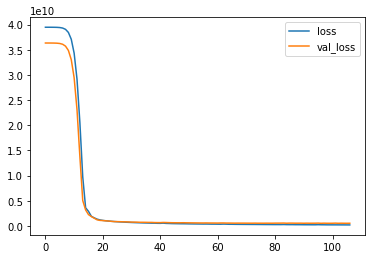

In [13]:
losses.plot()

model = create_model() # Resetting the model.

In [14]:
# Training the model with full training data and optimum number of epochs!!

history = model.fit(x=X,y=y,
          batch_size=128,epochs=104)
losses = pd.DataFrame(model.history.history)

Epoch 1/104
12/12 [==============================] - 1s 10ms/step - loss: 39868732652.3077
Epoch 2/104
12/12 [==============================] - 0s 9ms/step - loss: 39058503207.3846
Epoch 3/104
12/12 [==============================] - 0s 9ms/step - loss: 39862029075.6923
Epoch 4/104
12/12 [==============================] - 0s 9ms/step - loss: 38419778638.7692
Epoch 5/104
12/12 [==============================] - 0s 9ms/step - loss: 39838104339.6923
Epoch 6/104
12/12 [==============================] - 0s 9ms/step - loss: 39312944521.8462
Epoch 7/104
12/12 [==============================] - 0s 10ms/step - loss: 38633731623.3846
Epoch 8/104
12/12 [==============================] - 0s 9ms/step - loss: 38002559133.5385
Epoch 9/104
12/12 [==============================] - 0s 9ms/step - loss: 35745682668.3077
Epoch 10/104
12/12 [==============================] - 0s 9ms/step - loss: 35166673368.6154
Epoch 11/104
12/12 [==============================] - 0s 9ms/step - loss: 29219924283.0769
Epoch 

12/12 [==============================] - 0s 10ms/step - loss: 217299993.8462
Epoch 93/104
12/12 [==============================] - 0s 9ms/step - loss: 206241539.6923
Epoch 94/104
12/12 [==============================] - 0s 10ms/step - loss: 219230638.7692
Epoch 95/104
12/12 [==============================] - 0s 10ms/step - loss: 214444657.2308
Epoch 96/104
12/12 [==============================] - 0s 10ms/step - loss: 202690995.6923
Epoch 97/104
12/12 [==============================] - 0s 10ms/step - loss: 190737543.3846
Epoch 98/104
12/12 [==============================] - 0s 10ms/step - loss: 197862976.0000
Epoch 99/104
12/12 [==============================] - 0s 9ms/step - loss: 186312589.5385
Epoch 100/104
12/12 [==============================] - 0s 10ms/step - loss: 194584156.3077
Epoch 101/104
12/12 [==============================] - 0s 10ms/step - loss: 192246251.0769
Epoch 102/104
12/12 [==============================] - 0s 10ms/step - loss: 204128706.4615
Epoch 103/104
12/12 [=

<AxesSubplot:>

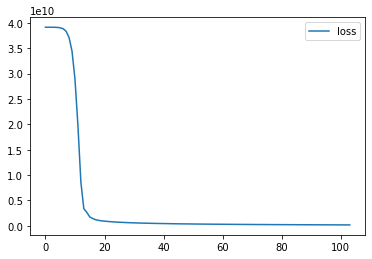

In [15]:
losses.plot()

# <center> Prediction & Evaluation

In [16]:
model.evaluate(X,y)

45/45 [==============================] - 0s 3ms/step - loss: 178466368.0000


178466368.0

In [17]:
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,Comp

In [18]:
X_result

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,...,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1460,1461,16.494888,14.104339,5,4.677073,1961,1961,0.000000,89.265771,7.758061,42.855421,304.163007,5.346044,0.000000,0.0,6.623018,0.000000,0.00000,1,0.000000,2,0.75096,1.819119,0.000000,1961.0,1.0,730.0,34.451354,0.000000,0.0,0.0,19.069698,0.0,0.000000,3922,309.509051,102.369876,1.000000,53.521052,0,0,1,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1461,1462,16.610808,14.551219,6,4.677073,1958,1958,14.607282,141.193750,0.000000,54.733383,424.835017,5.581083,0.000000,0.0,6.996108,0.000000,0.00000,1,1.069352,3,0.75096,1.978208,0.000000,1958.0,1.0,312.0,67.362290,9.059971,0.0,0.0,0.000000,0.0,10.242807,3916,430.416100,146.774833,1.534676,76.422261,0,0,1,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1462,1463,15.784137,14.482933,5,3.989638,1997,1998,0.000000,127.247724,0.000000,28.399580,317.034906,5.367239,831.868365,0.0,7.188328,0.000000,0.00000,2,1.069352,3,0.75096,1.978208,0.900816,1997.0,2.0,482.0,45.173547,8.781394,0.0,0.0,0.000000,0.0,0.000000,3995,1154.270510,964.483328,2.534676,53.954941,0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1463,1464,16.260928,13.776809,6,4.677073,1998,1998,6.148426,105.834812,0.000000,47.817445,316.477777,5.365938,803.758518,0.0,7.173732,0.000000,0.00000,2,1.069352,3,0.75096,2.116352,0.900816,1998.0,2.0,470.0,63.657564,9.059971,0.0,0.0,0.000000,0.0,0.000000,3996,1125.602233,914.959268,2.534676,72.717535,0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1464,1465,11.556456,12.345543,8,3.989638,1992,1992,0.000000,60.360939,0.000000,94.432166,412.029379,5.558976,0.000000,0.0,6.960600,0.000000,0.00000,2,0.000000,2,0.75096,1.819119,0.000000,1992.0,2.0,506.0,0.000000,14.005464,0.0,0.0,21.009504,0.0,0.000000,3984,417.588355,65.919916,2.000000,35.014968,0,0,1,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,7.529561,10.503896,4,5.345038,1970,1970,0.000000,0.000000,0.000000,65.309790,205.682488,5.041055,643.029826,0.0,6.810356,0.000000,0.00000,1,1.069352,3,0.75096,1.819119,0.0000

In [19]:
X_test = scale.transform(X_result)
result = model.predict(X_test)
result = pd.DataFrame(result,columns=['SalePrice'])
result.head()
result['Id'] = test['Id']
result = result[['Id','SalePrice']]
result.head()

,Id,SalePrice
0,1461,132900.453125
1,1462,161753.437500
2,1463,194120.343750
3,1464,191528.828125
4,1465,186422.703125


In [20]:
result.to_csv("submission.csv", index=False)

In [22]:
"""
sample_submission = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,20),linewidth=2)

ax1 = fig.add_subplot(211)
ax1.plot(result[['SalePrice']])

ax2 = fig.add_subplot(211)
ax2.plot(sample_submission[['SalePrice']])

plt.legend(["my","sample"], fontsize=15)
           
plt.xlabel('ID', fontsize=15);
plt.show()
"""

'\nsample_submission = pd.read_csv(\'../input/house-prices-advanced-regression-techniques/sample_submission.csv\')\n\nimport matplotlib.pyplot as plt\nfig = plt.figure(figsize=(20,20),linewidth=2)\n\nax1 = fig.add_subplot(211)\nax1.plot(result[[\'SalePrice\']])\n\nax2 = fig.add_subplot(211)\nax2.plot(sample_submission[[\'SalePrice\']])\n\nplt.legend(["my","sample"], fontsize=15)\n           \nplt.xlabel(\'ID\', fontsize=15);\nplt.show()\n'

# Conclusions and plans:

1. Currient score of this model at kaggle.com is 0.15 and it's good, but not enough, because our last model with blending has score 0,119
2. We need to try TensorFlow and PyTorch to improve the result. In general, even this model is a working tool without significant flaws, but it can be better
